## Important info about some parts of the code :

- grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='accuracy', verbose=2)

  - estimator=model: This is the model you're optimizing (in this case, the Random Forest classifier).
  - param_grid=param_grid: This is the grid of parameters to search over.
  - cv=cv: This specifies the cross-validation strategy (the StratifiedKFold we just created).
  - n_jobs=-1: This tells the process to use all available CPU cores, speeding up the search.
  - scoring='accuracy': This specifies that we want to use accuracy as our evaluation metric.
  - verbose=2: This sets the verbosity level, controlling the amount of output during the process.

- rf = Pipeline([
  ('scaler', StandardScaler()),
  ('rf', RandomForestClassifier(random_state=42, oob_score=True))
  ])

  - Δημιουργώ έναν αγωνγό επεξεργασίας και εκαπαίδευσης του Random Forest όπου τα δεδομένα περνούν διαδοχικά από διάφορα βήματα επεξεργασίας και εκπαίδευσης . Το πλεονέκτημα της χρήσης ενός Pipeline είναι ότι διασφαλίζει ότι οι ίδιοι μετασχηματισμοί (στην προκειμένη περίπτωση, η κλιμάκωση) εφαρμόζονται με συνέπεια τόσο στα δεδομένα εκπαίδευσης όσο και στα δεδομένα δοκιμής.

  Επιτρέπει επίσης την προεπεξεργασία και το μοντέλο ως έναν ενιαίο εκτιμητή, κάτι που είναι ιδιαίτερα χρήσιμο στη διασταυρούμενη επικύρωση και την αναζήτηση πλέγματος. Ο RandomForestClassifier αρχικοποιείται με random_state=42 για λόγους αναπαραγωγιμότητας και oob_score=True για τον υπολογισμό του out-of-bag score, το οποίο είναι ένας τρόπος για να λάβετε μια αμερόληπτη εκτίμηση της απόδοσης του μοντέλου χωρίς να χρειάζεστε ένα ξεχωριστό σύνολο επικύρωσης.

- Output : for this line : " print(classification_report(y_test , y_pred) "
  Δείχνει τις κύριες μετρικές ταξινόμησης για κάθε κλάση - συναίσθημα


### Simple Random Forest !


Model Evaluation:
Accuracy: 0.7369
Precision (weighted): 0.7364
Recall (weighted): 0.7369
F1-score (weighted): 0.7287

Cross-validation scores: [0.65459037 0.67298188 0.79571664 0.86779242 0.86243822]
Mean CV score: 0.7707 (+/- 0.1822)

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.79      0.85      0.81        13
       Active       0.80      0.57      0.67        14
        Adult       0.80      0.92      0.86        13
        Agile       0.64      0.64      0.64        14
     Alluring       0.47      0.69      0.56        13
      Amiable       0.65      0.79      0.71        14
      Amusing       0.71      0.77      0.74        13
      Aqueous       0.80      0.92      0.86        13
 Aristocratic       0.74      1.00      0.85        14
     Aromatic       0.79      0.79      0.79        14
     Artistic       0.87      1.00      0.93        13
Authoritative       0.69      0.85      0.76        13
       Bitter       0.81

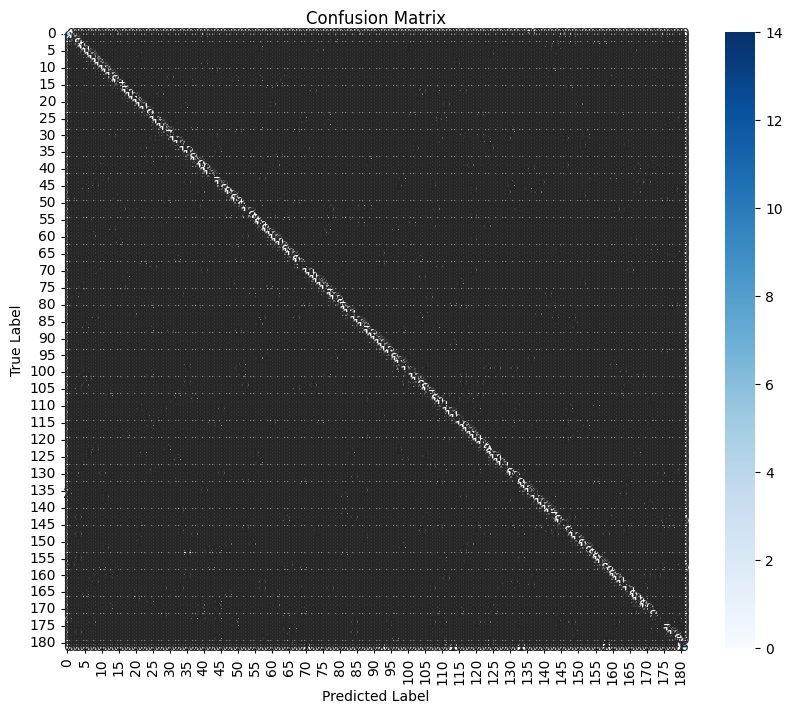

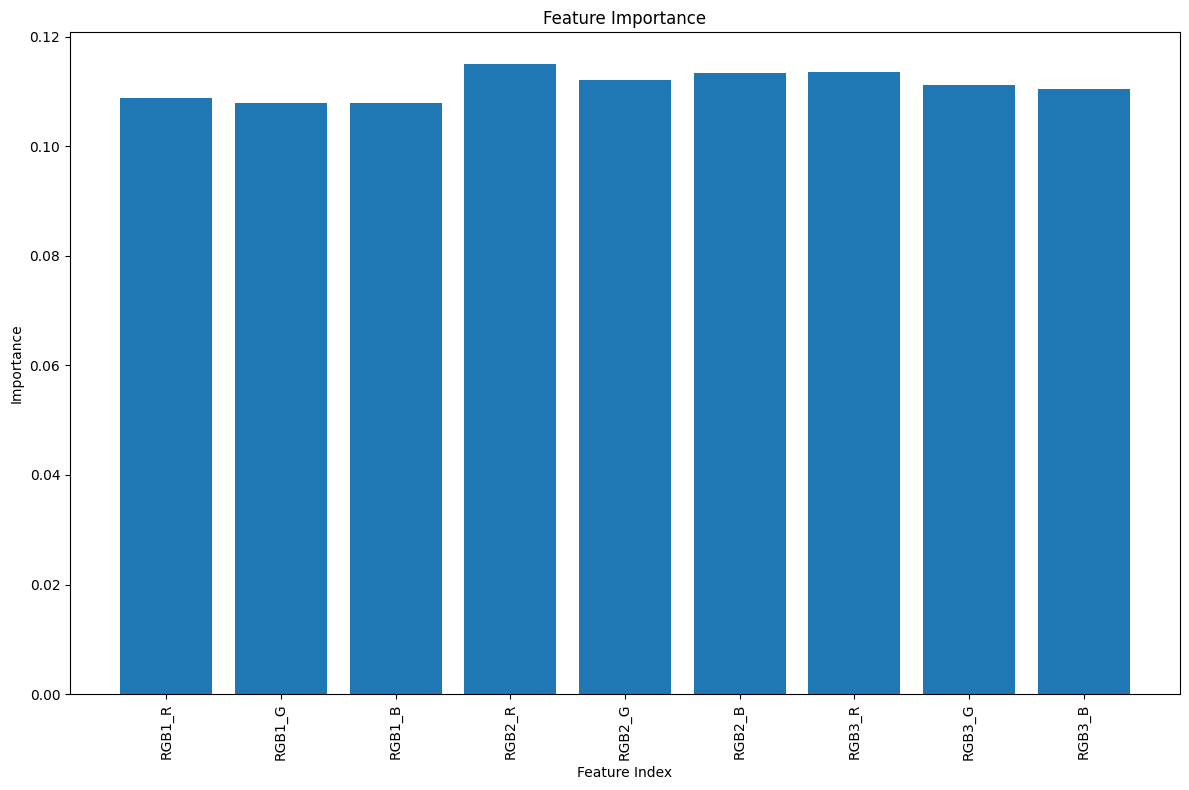

Feature RGB1_R: 0.1088
Feature RGB1_G: 0.1079
Feature RGB1_B: 0.1079
Feature RGB2_R: 0.1150
Feature RGB2_G: 0.1121
Feature RGB2_B: 0.1134
Feature RGB3_R: 0.1135
Feature RGB3_G: 0.1111
Feature RGB3_B: 0.1104


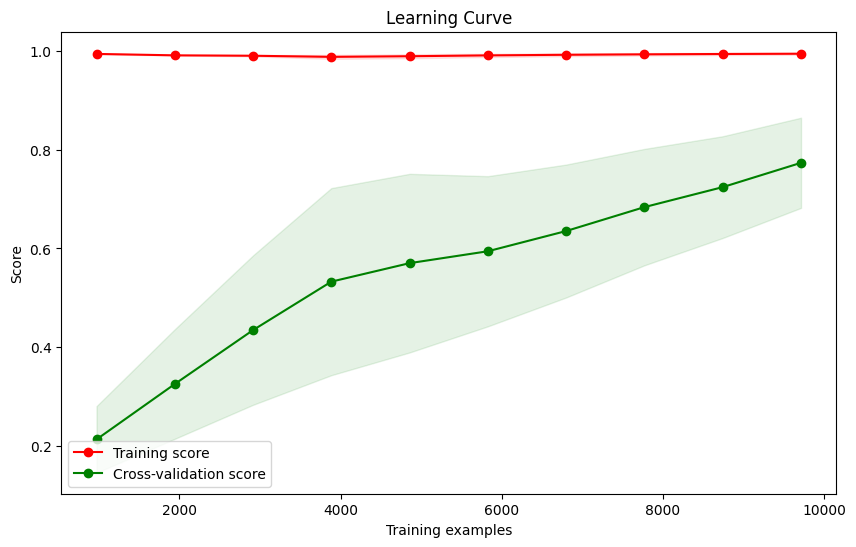


Model Fit Assessment:
Training Score: 0.9949
Testing Score: 0.7369
The model might be overfitting.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Load the dataset
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Features (RGB values), normalized
y = data.iloc[:, -1].values  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get the feature names from your dataset
feature_names = data.columns[:-1].tolist()  # Assuming the last column is the target

# Feature importance
feature_importance = rf_classifier.feature_importances_
plt.figure(figsize=(12, 8))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.xticks(range(len(feature_importance)), feature_names, rotation=90)
plt.tight_layout()
plt.show()

# Print feature importances
for i, importance in enumerate(feature_importance):
    print(f"Feature {feature_names[i]}: {importance:.4f}")

# Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    rf_classifier, X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Print overfitting/underfitting assessment
print("\nModel Fit Assessment:")
print(f"Training Score: {rf_classifier.score(X_train, y_train):.4f}")
print(f"Testing Score: {rf_classifier.score(X_test, y_test):.4f}")

if rf_classifier.score(X_train, y_train) - rf_classifier.score(X_test, y_test) > 0.1:
    print("The model might be overfitting.")
elif rf_classifier.score(X_train, y_train) < 0.65:
    print("The model might be underfitting.")
else:
    print("The model seems to have a good fit.")

### Improved approach ! Same with the above but use GridSearch , early-stopping , cross-validation for feature selection


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

# Load and preprocess the data
data = pd.read_csv('final_dataset.csv')
X = data.iloc[:, :-1].values / 255.0  # Normalize RGB values
y = data.iloc[:, -1].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Feature engineering
def create_color_features(X):
    X_new = np.column_stack((
        X,
        np.mean(X, axis=1),  # Mean intensity
        np.max(X, axis=1) - np.min(X, axis=1),  # Color range
        X[:, 0] / (X[:, 1] + X[:, 2] + 1e-10),  # Red ratio
        X[:, 1] / (X[:, 0] + X[:, 2] + 1e-10),  # Green ratio
        X[:, 2] / (X[:, 0] + X[:, 1] + 1e-10)   # Blue ratio
    ))
    return X_new

X_enhanced = create_color_features(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Define parameter space for RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', 'balanced_subsample', None]
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42, n_jobs=-1, scoring='f1_weighted')
random_search.fit(X_train_scaled, y_train_resampled)

# Get the best model
best_rf = random_search.best_estimator_

# Make predictions
y_pred = best_rf.predict(X_test_scaled)

# Evaluate the model
print("Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision (weighted): {precision_score(y_test, y_pred, average='weighted'):.4f}")
print(f"Recall (weighted): {recall_score(y_test, y_pred, average='weighted'):.4f}")
print(f"F1-score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Perform cross-validation
cv_scores = cross_val_score(best_rf, X_enhanced, y_encoded, cv=5, scoring='f1_weighted')
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Feature importance analysis
feature_names = ['R', 'G', 'B', 'Mean Intensity', 'Color Range', 'Red Ratio', 'Green Ratio', 'Blue Ratio']
importances = best_rf.feature_importances_
for name, importance in zip(feature_names, importances):
    print(f"Feature {name}: {importance:.4f}")

# Permutation importance
perm_importance = permutation_importance(best_rf, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_importances = pd.DataFrame({'feature': feature_names, 'importance': perm_importance.importances_mean})
perm_importances = perm_importances.sort_values('importance', ascending=False)
print("\nPermutation Importance:")
print(perm_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=perm_importances)
plt.title('Feature Importance (Permutation)')
plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_enhanced, y_encoded, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1_weighted')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend(loc="best")
plt.show()

# Print overfitting/underfitting assessment
print("\nModel Fit Assessment:")
print(f"Training Score: {best_rf.score(X_train_scaled, y_train_resampled):.4f}")
print(f"Testing Score: {best_rf.score(X_test_scaled, y_test):.4f}")

if best_rf.score(X_train_scaled, y_train_resampled) - best_rf.score(X_test_scaled, y_test) > 0.1:
    print("The model might be overfitting.")
elif best_rf.score(X_train_scaled, y_train_resampled) < 0.65:
    print("The model might be underfitting.")
else:
    print("The model seems to have a good fit.")

# Print best parameters
print("\nBest Parameters:")
print(random_search.best_params_)

Model Evaluation:
Accuracy: 0.7773
Precision (weighted): 0.7833
Recall (weighted): 0.7773
F1-score (weighted): 0.7724

Cross-validation scores: [0.6719403  0.70504678 0.81080137 0.86924807 0.85798115]
Mean CV score: 0.7830 (+/- 0.1606)

Classification Report:
               precision    recall  f1-score   support

     Abundant       0.80      0.92      0.86        13
       Active       0.75      0.64      0.69        14
        Adult       0.71      0.92      0.80        13
        Agile       0.71      0.71      0.71        14
     Alluring       0.67      0.62      0.64        13
      Amiable       0.71      0.86      0.77        14
      Amusing       0.75      0.69      0.72        13
      Aqueous       0.93      1.00      0.96        13
 Aristocratic       0.74      1.00      0.85        14
     Aromatic       0.86      0.86      0.86        14
     Artistic       0.87      1.00      0.93        13
Authoritative       0.73      0.85      0.79        13
       Bitter       0.87

ValueError: All arrays must be of the same length

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
import seaborn as sns
import time

# Custom Random Forest Classifier with Early Stopping
class EarlyStoppingRandomForestClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=100, **kwargs):
        self.n_estimators = n_estimators
        self.rf = RandomForestClassifier(warm_start=True, n_estimators=1, **kwargs)
        self.scores = []
    
    def fit(self, X, y, X_val=None, y_val=None):
        for i in range(1, self.n_estimators + 1):
            self.rf.n_estimators = i
            self.rf.fit(X, y)
            if X_val is not None and y_val is not None:
                score = balanced_accuracy_score(y_val, self.rf.predict(X_val))
                self.scores.append(score)
                if i > 5 and score < np.mean(self.scores[-6:-1]):
                    break
        return self
    
    def predict(self, X):
        return self.rf.predict(X)
    
    def predict_proba(self, X):
        return self.rf.predict_proba(X)   
# We create a custom Random Forest classifier that implements early stopping.
# This helps prevent overfitting by stopping the training process when the model's performance
# on a validation set stops improving. We use this instead of the standard RandomForestClassifier
# because scikit-learn's implementation doesn't have built-in early stopping.

# Load and preprocess the dataset
data = pd.read_csv('final_dataset_2.csv')
X = data.iloc[:, :-1].values / 255.0
y = data.iloc[:, -1].values
# We load the data and normalize the feature values to be between 0 and 1.
# This is important for RGB values, as it brings all features to the same scale.

# Encode the target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# We use LabelEncoder to convert string labels to numeric values.
# This is necessary because many machine learning algorithms, including Random Forest,
# require numeric input.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
# We split the data into training and testing sets. We use stratified sampling
# to ensure that the class distribution is preserved in both sets. This is crucial for
# imbalanced datasets to ensure that the model is evaluated on a representative sample.

# Cross-validated feature selection
def select_features_cv(X, y, estimator, k=5):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    selector = RFECV(estimator=estimator, step=1, cv=skf, scoring='balanced_accuracy', n_jobs=-1)
    selector = selector.fit(X, y)
    return selector
# We use Recursive Feature Elimination with Cross-Validation (RFECV) for feature selection.
# This method recursively removes features and uses cross-validation to select the best feature subset.
# We use this instead of simpler methods because it provides a more robust selection, especially
# for datasets with many features.

base_rf = RandomForestClassifier(n_estimators=100, random_state=42)
selector = select_features_cv(X_train, y_train, base_rf)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
# We apply the feature selection to our training and test sets. This reduces
# the dimensionality of our data, which can improve model performance and reduce overfitting.


# Calculate class weights
class_weights = dict(zip(np.unique(y_train), 
                         len(y_train) / (len(np.unique(y_train)) * np.bincount(y_train))))
# We calculate class weights to handle class imbalance. This gives more importance
# to underrepresented classes during training, helping the model to perform well across all classes.

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', class_weights]
}
# We define a grid of hyperparameters to search over. This allows us to find
# the best combination of parameters for our model. We include a range of values for each
# parameter to explore different model complexities.

# Set up GridSearchCV with Stratified K-Fold
grid_search = GridSearchCV(
    estimator=EarlyStoppingRandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1,
    scoring='balanced_accuracy'
)
# We use GridSearchCV to perform an exhaustive search over the specified parameter grid.
# We use stratified k-fold cross-validation to ensure each fold is representative of the whole dataset.
# We use balanced accuracy as the scoring metric to handle potential class imbalance.

# Perform Grid Search
print("Performing Grid Search for Random Forest...")
start_time = time.time()
grid_search.fit(X_train_selected, y_train)
end_time = time.time()
# This step performs the actual grid search, fitting models with all combinations
# of parameters and selecting the best one based on cross-validation performance.

print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get the best model
best_rf = grid_search.best_estimator_

# Perform cross-validation on the best model
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracies = []
all_y_true = []
all_y_pred = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_selected, y_train), 1):
    X_train_fold, X_val_fold = X_train_selected[train_index], X_train_selected[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
    best_rf.fit(X_train_fold, y_train_fold, X_val=X_val_fold, y_val=y_val_fold)
    y_pred = best_rf.predict(X_val_fold)
    
    accuracy = accuracy_score(y_val_fold, y_pred)
    accuracies.append(accuracy)
    
    all_y_true.extend(y_val_fold)
    all_y_pred.extend(y_pred)
    
    print(f"Fold {fold}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1_score(y_val_fold, y_pred, average='weighted'):.4f}")
    print()

# Print overall results
print("\nRandom Forest Results:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} (+/- {np.std(accuracies):.4f})")

# Calculate and print F1-score, precision, and recall
f1 = f1_score(all_y_true, all_y_pred, average='weighted')
precision = precision_score(all_y_true, all_y_pred, average='weighted')
recall = recall_score(all_y_true, all_y_pred, average='weighted')
print(f"F1-score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print(f"Training time: {end_time - start_time:.2f} seconds")

# Generate classification report
class_names = le.classes_
print("\nClassification Report:")
print(classification_report(all_y_true, all_y_pred, target_names=class_names))

# Generate confusion matrix
plt.figure(figsize=(20, 16))
cm = confusion_matrix(all_y_true, all_y_pred)
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Evaluate on the test set
y_test_pred = best_rf.predict(X_test_selected)

print("\nTest Set Evaluation:")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test F1-score: {f1_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred, average='weighted'):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred, average='weighted'):.4f}")

# Print model complexity
n_estimators = best_rf.rf.n_estimators
max_depth = best_rf.rf.max_depth if best_rf.rf.max_depth is not None else "None"
print(f"\nNumber of trees: {n_estimators}")
print(f"Max depth: {max_depth}")

# Feature importance analysis
feature_importance = best_rf.rf.feature_importances_
selected_features = selector.support_
feature_names = data.columns[:-1][selected_features]

# Sort feature importances in descending order
indices = np.argsort(feature_importance)[::-1]

# Print the feature ranking
print("\nTop 10 Feature ranking:")
for f in range(min(10, X_train_selected.shape[1])):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], feature_importance[indices[f]]))

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.bar(range(min(10, X_train_selected.shape[1])), feature_importance[indices][:10])
plt.xticks(range(min(10, X_train_selected.shape[1])), [feature_names[i] for i in indices][:10], rotation=90)
plt.tight_layout()
plt.show()

# Plot learning curve
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10), scoring='balanced_accuracy'
    )
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()
    plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                     np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1, color="r")
    plt.fill_between(train_sizes, np.mean(test_scores, axis=1) - np.std(test_scores, axis=1),
                     np.mean(test_scores, axis=1) + np.std(test_scores, axis=1), alpha=0.1, color="g")
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="r", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

# Call the function after training
plot_learning_curve(best_rf, X_train_selected, y_train, "Learning Curve for Random Forest")